In [1]:
from scipy import spatial
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer

In [2]:
model_name = "stsb-mpnet-base-v2"
device = "cuda"
sbert_model = SentenceTransformer(model_name, device=device)

In [3]:
train_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/train_final.csv")
val_split = pd.read_csv("/home/evgenii/Desktop/ml_hw/NamePrompt/data/val_final.csv")


In [40]:
zeros = []
ones = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)        

1564it [00:19, 81.35it/s]


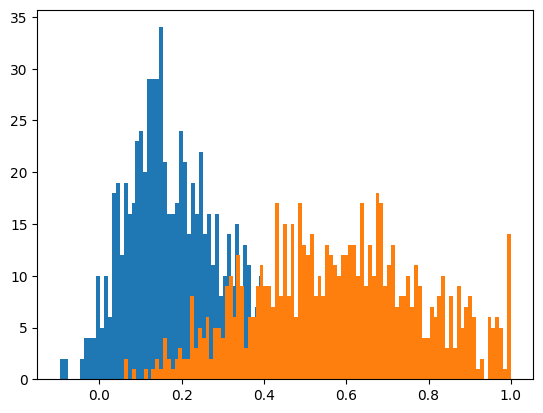

In [41]:
plt.hist(zeros, bins=100)
plt.hist(ones, bins=100)
plt.plot()
plt.show()

(array([  8.,  32.,  63.,  86., 116., 114., 127.,  75.,  67.,  46.]),
 array([0.06052402, 0.15447162, 0.24841922, 0.34236682, 0.43631441,
        0.53026201, 0.62420961, 0.71815721, 0.8121048 , 0.9060524 ,
        1.        ]),
 <BarContainer object of 10 artists>)

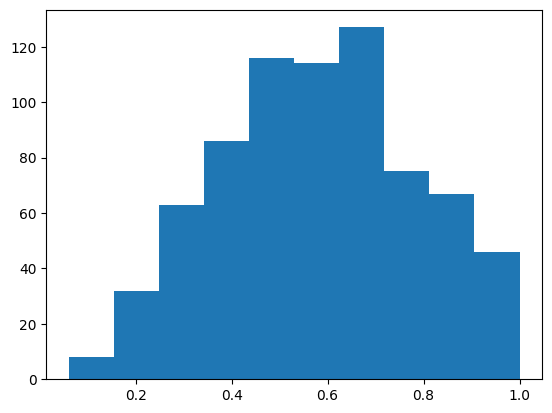

In [42]:
plt.hist(ones)

(array([ 28., 145., 235., 173.,  97.,  52.,  57.,  28.,  11.,   4.]),
 array([-9.61638242e-02,  5.69216907e-04,  9.73022580e-02,  1.94035299e-01,
         2.90768340e-01,  3.87501381e-01,  4.84234422e-01,  5.80967464e-01,
         6.77700505e-01,  7.74433546e-01,  8.71166587e-01]),
 <BarContainer object of 10 artists>)

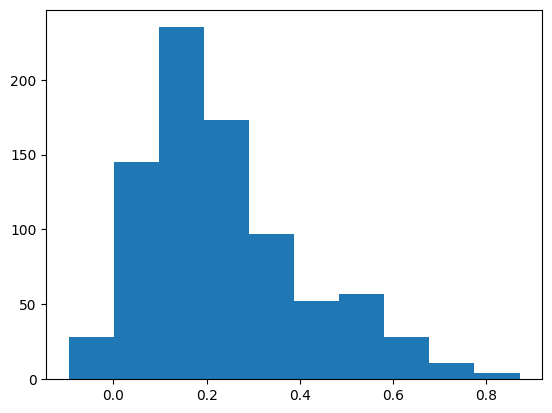

In [43]:
plt.hist(zeros)

<h1>Train</h1>

In [4]:
sbert_model.train()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [5]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

#Define your train examples. You need more than just two examples...
train_examples = []
val_examples_0 = []
val_examples_1 = []
val_scores = []
train_drop = []
val_drop = []

for idx, row in tqdm(train_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    for sentence in sentences:
        if isinstance(sentence, float):
            print(idx)
            train_drop.append(idx)
    target = row["is_duplicate"]
    train_examples.append(InputExample(texts=sentences, label=float(target)))
    
for idx, row in tqdm(val_split.iterrows()):
    target = row["is_duplicate"]
    val_examples_0.append(row["name_1"])
    val_examples_1.append(row["name_2"])
    if isinstance(row["name_1"], float):
            print(idx, row["name_1"])
            val_drop.append(idx)
    if isinstance(row["name_2"], float):
            print(idx, row["name_2"])
            val_drop.append(idx)
    val_scores.append(float(target))

6228it [00:00, 18509.58it/s]
1558it [00:00, 16010.83it/s]


In [6]:
from sentence_transformers import evaluation
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_examples_0, val_examples_1, val_scores)

In [7]:
#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
train_loss = losses.CosineSimilarityLoss(sbert_model)
#Tune the model
sbert_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50,
                output_path ="/home/evgenii/Desktop/ml_hw/NamePrompt/models",
                evaluator=evaluator, evaluation_steps=100, show_progress_bar=True)

Iteration:  13%|█▎        | 99/779 [00:15<01:48,  6.25it/s]

Eval METRIC: 0.9857311975873655


Iteration:  26%|██▌       | 201/779 [00:39<09:53,  1.03s/it]

Eval METRIC: 0.9855443639057166


Iteration:  38%|███▊      | 299/779 [00:55<01:13,  6.51it/s]

Eval METRIC: 0.98779794185339


Iteration:  51%|█████     | 399/779 [01:17<01:03,  5.99it/s]

Eval METRIC: 0.9884063913653078


Iteration:  64%|██████▍   | 499/779 [01:39<00:42,  6.60it/s]

Eval METRIC: 0.988642826909341


Iteration:  77%|███████▋  | 599/779 [02:02<00:27,  6.64it/s]

Eval METRIC: 0.9894744848019893


Iteration:  90%|████████▉ | 699/779 [02:24<00:12,  6.56it/s]

Eval METRIC: 0.9900201052882198


Iteration: 100%|██████████| 779/779 [02:44<00:00,  4.74it/s]


Eval METRIC: 0.9907393322927965


Iteration:  13%|█▎        | 101/779 [00:19<11:22,  1.01s/it]

Eval METRIC: 0.9904367609322504


Iteration:  26%|██▌       | 199/779 [00:34<01:29,  6.50it/s]

Eval METRIC: 0.9907922409460068


Iteration:  39%|███▊      | 301/779 [01:01<08:08,  1.02s/it]

Eval METRIC: 0.9902565408322531


Iteration:  51%|█████▏    | 401/779 [01:20<06:22,  1.01s/it]

Eval METRIC: 0.9900647469643661


Iteration:  64%|██████▍   | 500/779 [01:40<06:29,  1.40s/it]

Eval METRIC: 0.9904483347001402


Iteration:  77%|███████▋  | 601/779 [02:00<03:01,  1.02s/it]

Eval METRIC: 0.9903921192561044


Iteration:  90%|████████▉ | 701/779 [02:19<01:18,  1.01s/it]

Eval METRIC: 0.9907310653157325


Iteration: 100%|██████████| 779/779 [02:31<00:00,  5.14it/s]


Eval METRIC: 0.9907955477368323


Epoch: 100%|██████████| 2/2 [05:30<00:00, 165.22s/it]


<h1>Metrics</h1>

In [26]:
sbert_model = SentenceTransformer("/home/evgenii/Desktop/ml_hw/NamePrompt/models/", device=device)

In [27]:
sbert_model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [101]:
zeros = []
ones = []
predicts = []
raw_predicts = []
for idx, row in tqdm(val_split.iterrows()):
    sentences = [row["name_1"], row["name_2"]]
    target = row["is_duplicate"]
    sentence_embeddings = sbert_model.encode(sentences)
    result = 1 - spatial.distance.cosine(*sentence_embeddings)
    if result > 0.5:
        label = 1
    else:
        label = 0
    predicts.append(label)
    if target == 0:
        zeros.append(result)
    else:
        ones.append(result)    

1558it [00:20, 76.89it/s]


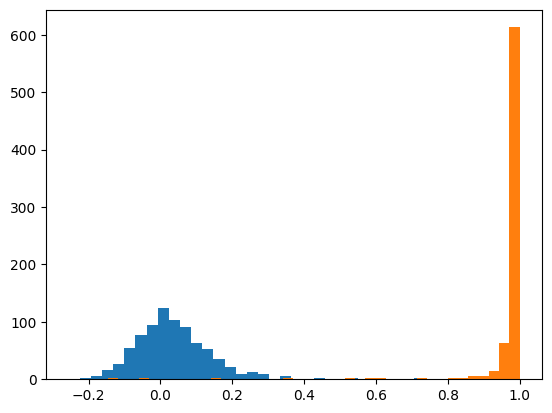

In [29]:
plt.hist(zeros, bins=40)
plt.hist(ones, bins=40)
plt.plot()
plt.show()

In [73]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay

In [102]:
f1_score(predicts, val_split["is_duplicate"].to_list())

0.9808481532147743

In [103]:
precision_score(predicts, val_split["is_duplicate"].to_list())

0.9768392370572208

In [104]:
recall_score(predicts, val_split["is_duplicate"].to_list())

0.9848901098901099

In [39]:
roc_auc_score(val_split["is_duplicate"].to_list(), raw_predicts)

0.9907955477368322

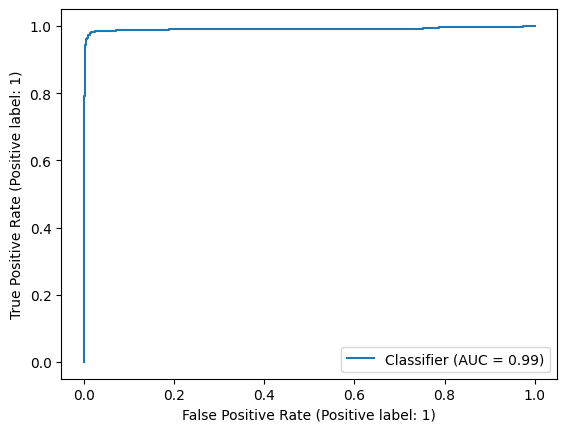

In [41]:
RocCurveDisplay.from_predictions(val_split["is_duplicate"].to_list(), raw_predicts)

<h1>Check Range</h1>

In [64]:
emb_dict = {}
def make_embedings():
    all_records = val_split.iloc[:, :2].values.flatten()
    embedings = []
    for record in tqdm(all_records):
        sentence_embedding = sbert_model.encode([record])[0]
        emb_dict[record] = sentence_embedding
make_embedings()

100%|██████████| 3116/3116 [00:34<00:00, 91.08it/s]


In [91]:
def get_close_results(company, top_k=3):
    sentence_embedding = sbert_model.encode([company])[0]
    results = []
    for k,v in emb_dict.items():
        result = 1 - spatial.distance.cosine(v, sentence_embedding)
        results.append([k, result])
        
    output = pd.DataFrame(sorted(results,key=lambda x: x[1], reverse=True)[:top_k], columns=[["Name", "Score"]])
    return output

In [113]:
get_close_results("sika cambodia", top_k=3)

,Name,Score
0,sika cambodia .,0.996033
1,sika thailand,0.993913
2,sika cambodia . warehouse,0.993101


In [114]:
get_close_results("bridgestoun2228", top_k=3)

,Name,Score
0,bridgestone india pvt . .,0.947484
1,bridgestone huizhou)synthetic rubber .,0.946918
2,bridgestone china research development .,0.946626


In [116]:
get_close_results("soup and salad", top_k=3)

,Name,Score
0,hindustan coca cola beverages pvt . .,0.318610
1,c.o.i.m . s.p.a . chimica organica industriale...,0.312836
2,kitchens industria comercio ltda,0.299295
